<a href="https://colab.research.google.com/github/AndrewEPrince/codespaces-blank/blob/main/BallsNetUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installations
!pip install keras --upgrade -q

In [ ]:
#@title Imports
from google.colab import data_table
data_table.enable_dataframe_formatter()

import requests
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model
from keras import backend as K

from joblib import load

!git clone https://github.com/AndrewEPrince/codespaces-blank.git

fatal: destination path 'codespaces-blank' already exists and is not an empty directory.


In [ ]:
#@title Load Model
K.clear_session()

model = load_model("/content/codespaces-blank/ballsnet1.2.keras")
scaler = load(open("/content/codespaces-blank/ballsnet_scaler.joblib", "rb"))

In [ ]:
#@title Get Data From API
#@markdown Enter a URL for a group
url = "https://ballchasing.com/api/groups/testing-rkmp6qipbj/" #@param {type: "string"}
#@markdown Enter your API key
api_key = '8wjl1G9d8V8Ymfju7hH8K57aKNUiNhYe5oOYOxNr' #@param {type: "string"}
headers = {'Authorization': api_key }
response = requests.get(url, headers=headers)
data = json.loads(response.text)
df = pd.json_normalize(data)



In [ ]:
#@title Prediciton Options
all_players = False #@param {type: "boolean"}
#@markdown If ```all_players = False```, enter the index of desired players e.g. 0,3,5,9 or 5 otherwise leave blank.

indices_of_players = '16,3,5' #@param {type: "string"}

In [ ]:
#@title Parse Data
#@markdown Only shows first 20 columns.
data_table.enable_dataframe_formatter()

for i in range(len(df)):
  data_df = pd.DataFrame(pd.json_normalize(df.iloc[i]['players']))
  for j in range(len(data_df)):
    temp_df = pd.DataFrame(data_df.iloc[j]).T
    player_df = temp_df if i == 0 and j == 0 else pd.concat([player_df, temp_df])

display(player_df.iloc[:, : 20])

temp_player_df = player_df.drop(columns=['platform'], axis=1)
temp_player_df = temp_player_df.drop(columns=['id'], axis=1)
names = temp_player_df['name']
temp_player_df = temp_player_df.drop(columns=['name'], axis=1)
temp_player_df = temp_player_df.drop(columns=['team'], axis=1)
temp_player_df = temp_player_df.drop(columns=['cumulative.games'], axis=1)

x = np.asarray(temp_player_df)

x_scaled = scaler.transform(x)

,platform,id,name,team,cumulative.games,cumulative.wins,cumulative.win_percentage,cumulative.play_duration,cumulative.core.shots,cumulative.core.shots_against,cumulative.core.goals,cumulative.core.goals_against,cumulative.core.saves,cumulative.core.assists,cumulative.core.score,cumulative.core.mvp,cumulative.core.shooting_percentage,cumulative.boost.bpm,cumulative.boost.bcpm,cumulative.boost.avg_amount
0,Steam,76561198095299367,& G r i f f i n,& G r i f f i n & Andrew & Dani Rojas,1,1,100.0,324,4,3,1,1,2,0,407,0,25.0,344.0,338.8889,57.89
1,Steam,76561198261927096,-DreamZ-,xVLaaDdy16x & David Reinbacher & -DreamZ-,1,1,100.0,395,3,1,4,1,0,2,687,0,133.33333,316.0,299.2405,52.860004
2,Epic,b85f8831da6346b7a425fb058fa977b0,.kire,C & .kire & mrsalty248,1,0,0.0,324,3,7,1,4,2,0,414,0,33.333332,503.0,515.0,52.369995
3,Epic,5e95db3ee99f4ae8b4292b5bbc304721,0Olympus,Madcow678 & 0Olympus & Kellyzhero,1,1,100.0,413,2,6,1,2,1,0,345,0,50.0,262.0,251.477,59.86
4,Epic,21934dcbce664e1eb7d90695f450a227,2Chawnky,arq108 & MaximumEffort43 & 2Chawnky,1,0,0.0,447,2,9,1,3,4,1,570,0,50.0,326.0,319.32886,48.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,Steam,76561198400469880,zeroh,zeroh & Tru_Zzz TTV & Andrew,1,0,0.0,346,2,5,0,3,0,0,108,0,0.0,367.0,384.62427,52.670002
543,XBox,zhawk18,zhawk18,Andrew & scorched & zhawk18,1,1,100.0,220,2,3,1,0,0,1,222,0,50.0,277.0,253.63637,40.77
544,Steam,76561197963231253,zpecimen guy,zpecimen guy & Rascalage & ChubySavageTuler,1,0,0.0,291,2,4,1,5,0,1,252,0,50.0,356.0,357.1134,47.3
545,XBox,zrtor,zrtor,nudy. & KDeception & zrtor,1,1,100.0,321,2,9,0,0,2,0,212,0,0.0,348.0,348.41122,56.799995


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


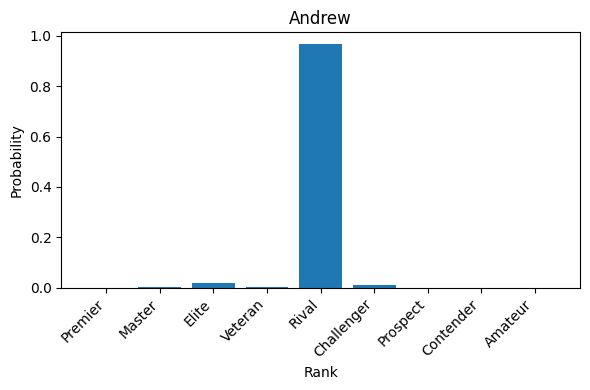

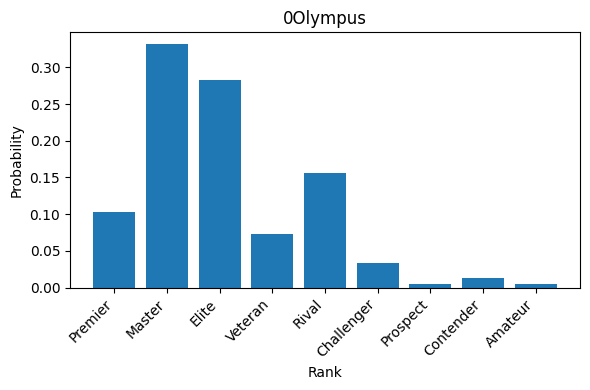

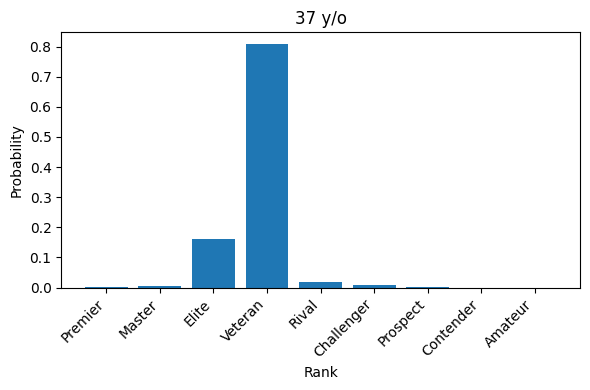

In [ ]:
#@title Run Prediction
# Convert indices_of_players to a list of integers
selected_indices = [int(i) for i in indices_of_players.split(',')]

if all_players:
    # Use all players
    x_scaled_selected = x_scaled
    selected_names = names
else:
    # Use only the selected players if the indices are within the valid range
    if all(index < len(x_scaled) for index in selected_indices):
        x_scaled_selected = x_scaled[selected_indices]
        selected_names = [names[i] for i in selected_indices]
    else:
        print("Invalid indices provided. Using all players.")
        x_scaled_selected = x_scaled
        selected_names = names

predictions = model.predict(x_scaled_selected, batch_size=None, verbose=1)

classes = [
    "Premier",
    "Master",
    "Elite",
    "Veteran",
    "Rival",
    "Challenger",
    "Prospect",
    "Contender",
    "Amateur"
]

num_classes = len(classes)

for i, (pred, player_name) in enumerate(zip(predictions, selected_names)):
    plt.figure(figsize=(6, 4))
    plt.bar(range(num_classes), pred)
    plt.xlabel('Rank')
    plt.ylabel('Probability')
    plt.title(f'{player_name}')
    plt.xticks(range(num_classes), classes, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()